**Author**: Andy Tzanidakis \
**Date**: 11/15/2023

In [1]:
import numpy as np
from astropy.timeseries import LombScargle
from astropy.io import ascii
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

In [2]:
# Load ELASTICC photometry
phot = ascii.read("../data/rrl_sample.ascii") # or you can choose eb_sample.ascii

In [3]:
phot.meta, phot

(OrderedDict([('true_period', 0.5802)]),
 <Table length=208>
    mjd        flux     flux_err band
  float64    float32    float32  str1
 ---------- ---------- --------- ----
 60278.2911  3681.0315  36.57585    z
 60283.2863 -1764.3602 13.710005    g
 60283.3028 -2300.0173 17.559978    r
  60285.312  2187.8438 28.773987    i
 60287.1184  100.92697 23.158018    u
 60290.2895 -235.33426 22.382057    u
 60290.3059 -2714.4348 20.622112    g
 60291.0925  546.45776  27.38656    u
 60291.1096  2672.9253  23.64777    g
 60295.1306   4244.068 28.945269    g
  60295.148  3721.0884   29.6886    r
        ...        ...       ...  ...
 61364.2708 -2227.3157 26.439526    i
 61364.2879 -1745.2043 30.833288    z
 61365.3138 -1796.6178 18.645939    g
 61365.3331 -1679.2498 21.881714    r
 61366.3019   862.8603 31.144424    z
 61366.3169  605.03534 48.903126    Y
 61368.3075 -3052.1965 34.953777    z
 61368.3212 -3147.9678 55.378635    Y
 61378.1801 -3376.2844 24.747478    r
 61378.1969 -2064.6245 25.5

In [4]:
# select a single filter 
rf = phot['band']=='r'

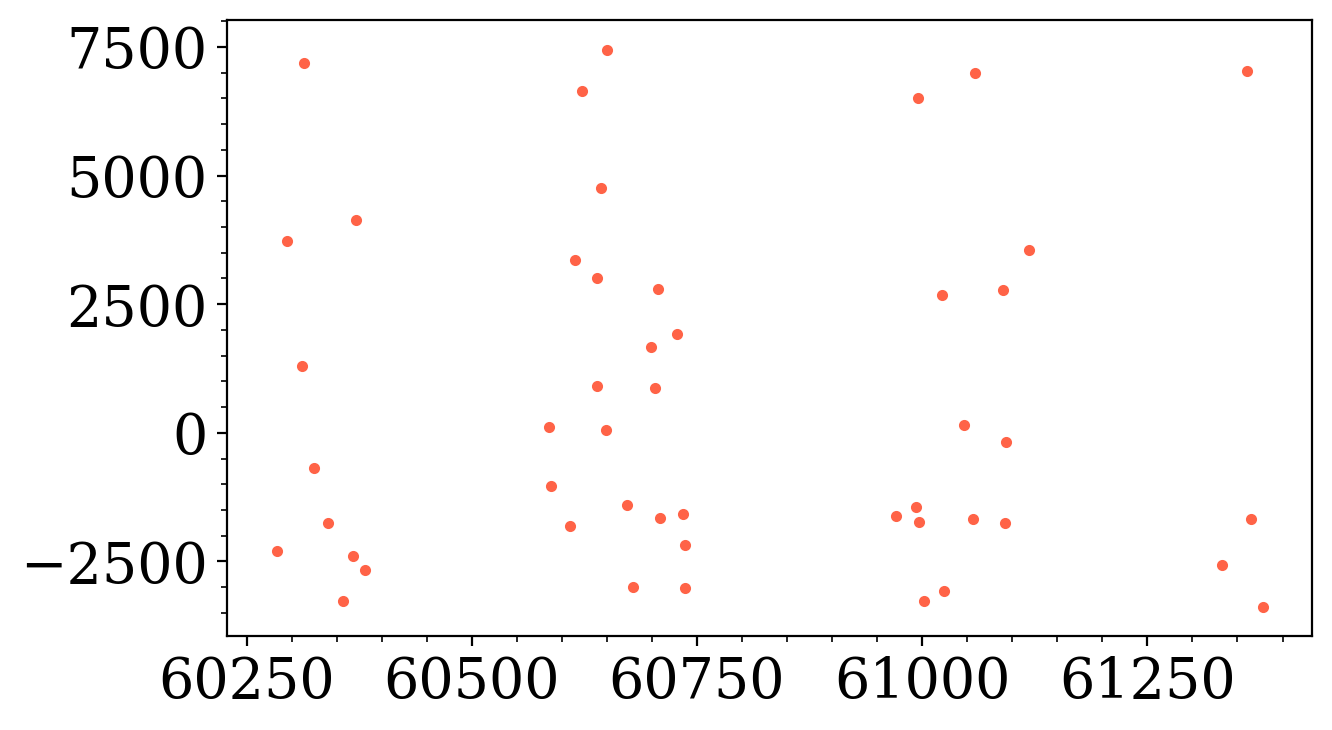

In [5]:
plt.figure(figsize=(7,4))
plt.errorbar(phot['mjd'][rf], 
            phot['flux'][rf], 
            yerr=phot['flux_err'][rf], 
            fmt='.', 
            color='tomato')
plt.minorticks_on()

## Automatic Periodogram Grid

Source code: https://github.com/astroML/gatspy/blob/71384b8d15531bc01a6b85250a35cd675edccf44/gatspy/periodic/modeler.py#L94

In [6]:
def compute_optimized_periodogram_grid(x0, oversampling_factor=5, nyquist_factor=3):
    """
    Computes an optimized periodogram frequency grid for a given time series. 
    
    Implemented in https://github.com/astroML/gatspy/blob/71384b8d15531bc01a6b85250a35cd675edccf44/gatspy/periodic/modeler.py#L94

    Parameters:
    - x0 (array-like): The input time axis.
    - oversampling_factor (int, optional): The oversampling factor for frequency grid. Default is 5.
    - nyquist_factor (int, optional): The Nyquist factor for frequency grid. Default is 3.

    Returns:
    - array: The computed optimized periodogram frequency grid.
    """

    # Number of data points in the time series
    num_points = len(x0)

    # Calculate the baseline of the time series
    baseline = np.max(x0) - np.min(x0)

    # Calculate the frequency resolution based on oversampling factor and baseline
    frequency_resolution = 1. / baseline / oversampling_factor

    # Calculate the number of frequencies and the frequency grid
    num_frequencies = int(0.5 * oversampling_factor * nyquist_factor * num_points)
    frequencies = frequency_resolution + frequency_resolution * np.arange(num_frequencies)

    return frequencies

In [7]:
# Create a LombScargle Periodogram Model
lsp = LombScargle(phot['mjd'][rf],
                  phot['flux'][rf],
                  dy = phot['flux_err'][rf],
                  fit_mean=True,
                  center_data=True,
                  nterms=1, 
                 normalization='standard')

In [8]:
a, b = lsp.autopower(samples_per_peak=50, nyquist_factor=100)

In [9]:
# Determine optimal frequency grid
f_grid = compute_optimized_periodogram_grid(phot['mjd'][rf],
                                            oversampling_factor=0.3, nyquist_factor=100)
power = lsp.power(f_grid) # compute power

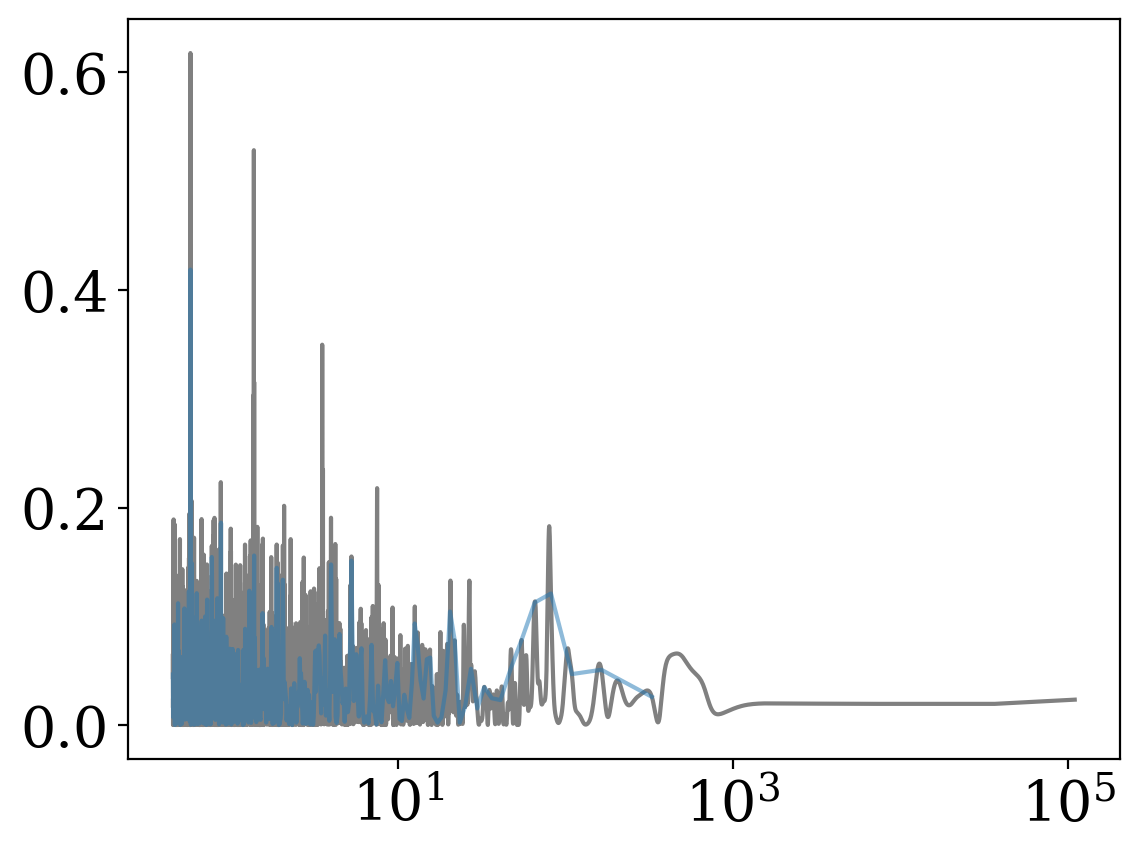

In [10]:
plt.plot(1/a, b, color='gray')

plt.plot(1/f_grid, power, alpha=0.5)

plt.xscale('log')

<function matplotlib.pyplot.minorticks_on()>

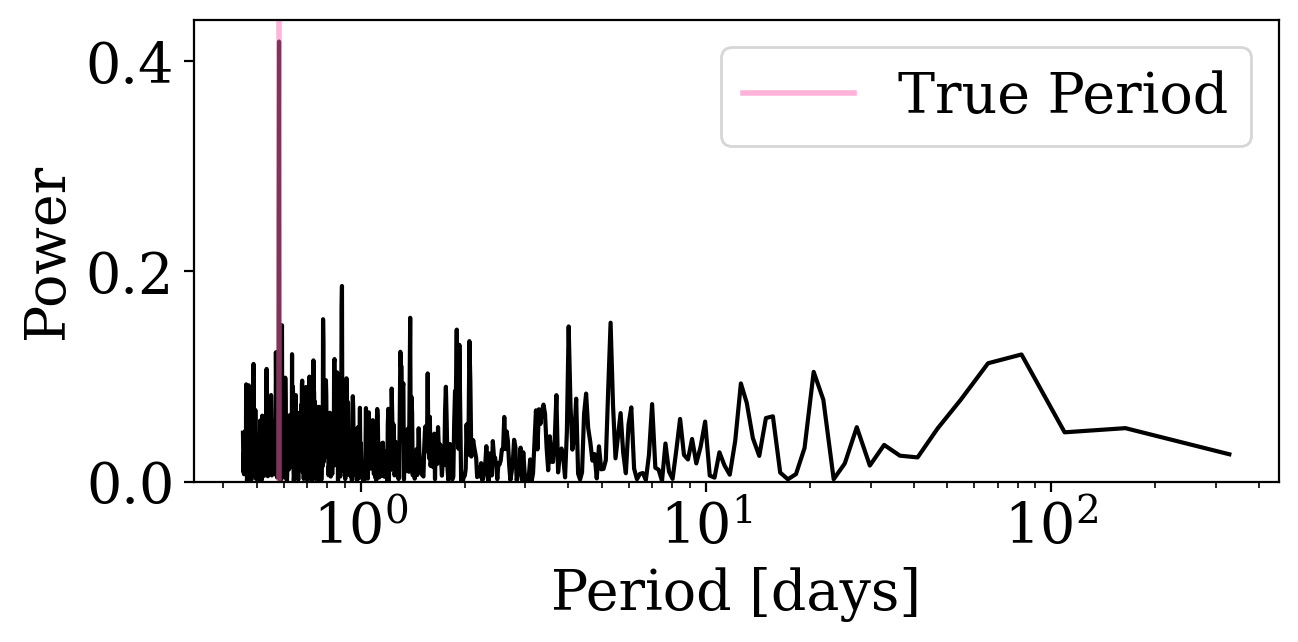

In [11]:
plt.figure(figsize=(7, 3))
plt.plot(1/f_grid, power, color='k')
plt.axvline(0.5802, color='hotpink', lw=2, alpha=0.5, 
           label='True Period')
plt.legend()
plt.ylim(0)
plt.xscale('log')
plt.ylabel("Power")
plt.xlabel("Period [days]")
plt.minorticks_on

In [149]:
N = 10
times = np.linspace(0, 8*np.pi, N) + np.random.normal(2, 1e1, N)
fluxes = np.sin(0.3 * times) + np.random.normal(0, 0.03, N) + 5
eers = 1 + np.zeros(N)

<ErrorbarContainer object of 3 artists>

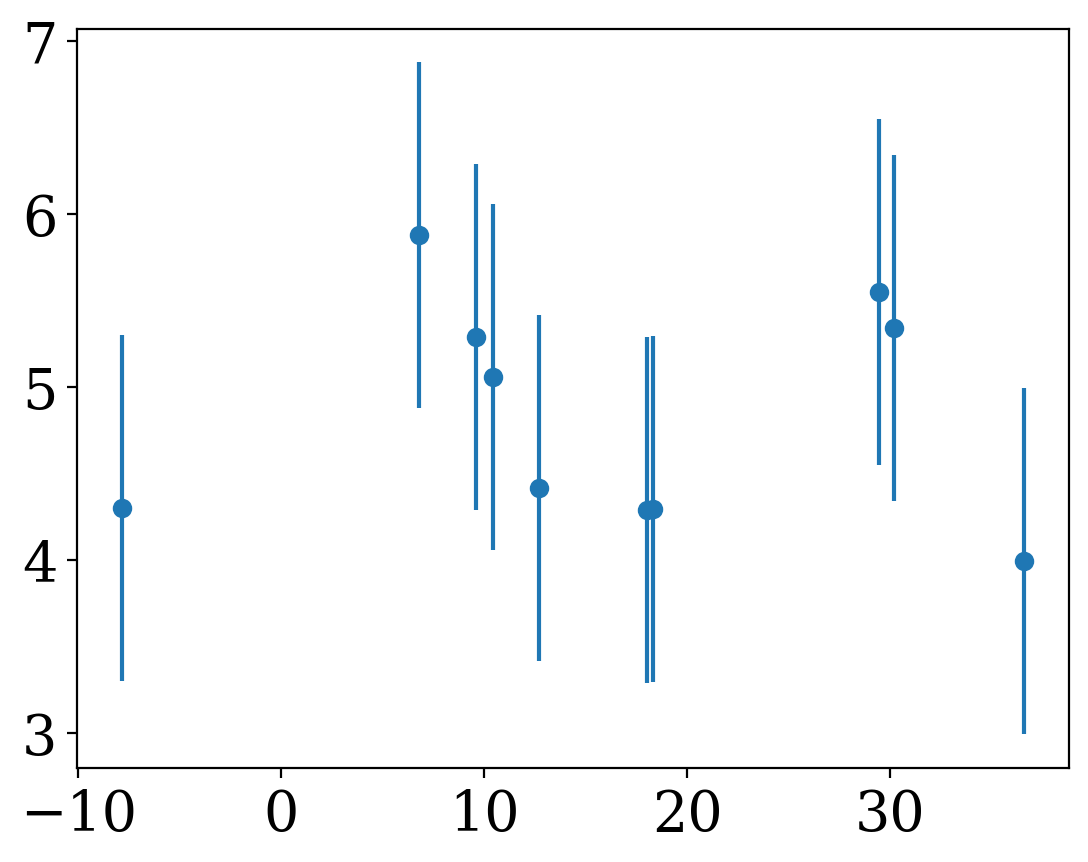

In [150]:
plt.errorbar(times, fluxes, yerr=eers, fmt='o')

In [151]:
lsp = LombScargle(times,
                  fluxes,
                  eers,
                  fit_mean=True,
                  center_data=True,
                  nterms=1, 
                 normalization='standard')

In [152]:
# Determine optimal frequency grid
f_grid = compute_optimized_periodogram_grid(times,
                                            oversampling_factor=5, nyquist_factor=100)
power = lsp.power(f_grid) # compute power

In [153]:
power

array([0.08328024, 0.07284486, 0.05525904, ..., 0.02047555, 0.0120685 ,
       0.05434633])

(0.0, 2.0)

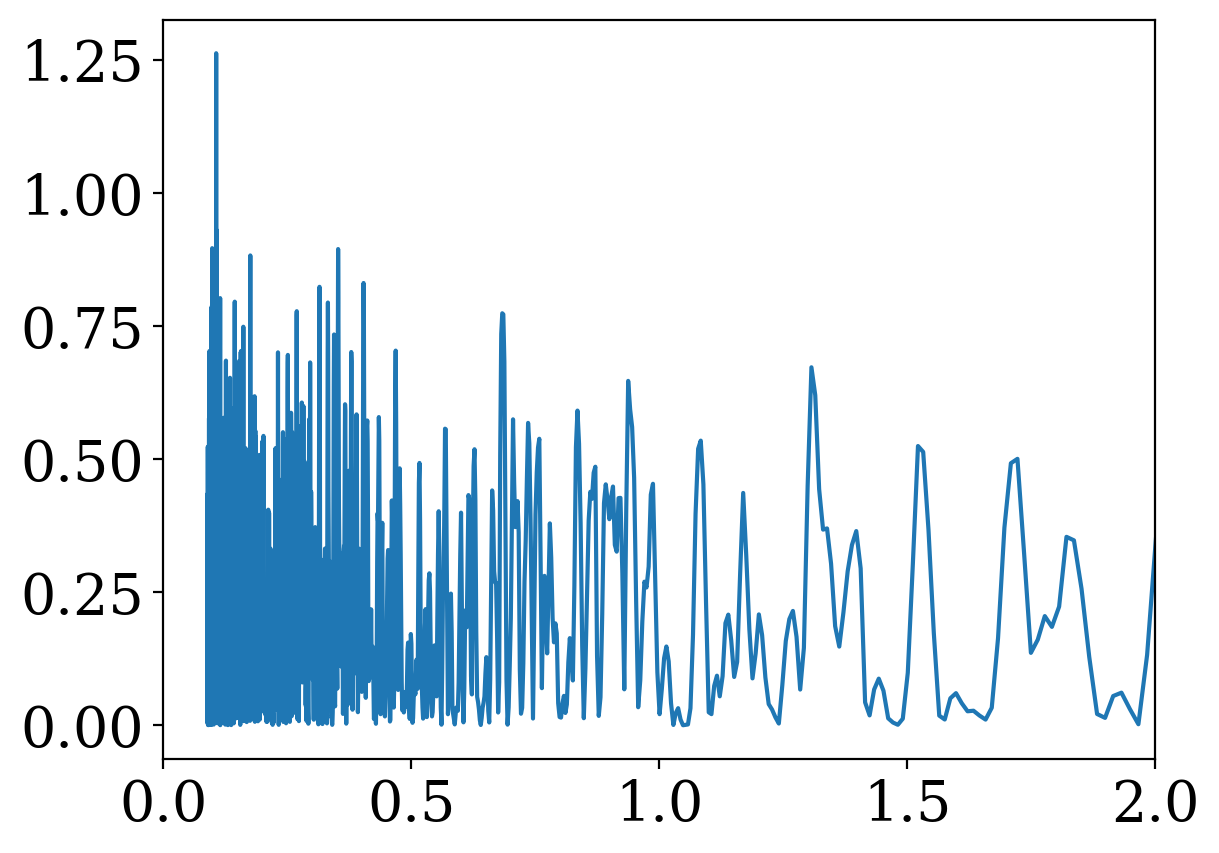

In [157]:
plt.plot(1/f_grid, power)
plt.xlim(0, 2)